### Due to large file size and limited space, the data files are not uploaded in this folder. 

**Kindly follow and run through the steps in the README files in the following folders sequentially in the order below (so that all the pre-requisite files can be generated) before running through the 'Restaurant Recommender.ipynb' workbook in this folder.**
0. Datasets
1. Processing of Yelp dataset
2. Part 1 - Fake reviews

In [1]:
# Import standard libraries
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from collections import Counter, defaultdict

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


# Import sklearn packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity


# Import surprise libraries for recommender systems
from surprise import Reader, Dataset, SVD, KNNBasic, KNNWithMeans
from surprise.accuracy import rmse
from surprise import dump
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV, cross_validate, KFold


# Import other packages
from datetime import datetime
import pickle
from ast import literal_eval
from math import sqrt
import operator

### 1) Load and prepare files for recommender systems

In [3]:
# Connect to sqlite3 database

conn = sqlite3.connect('C:/Users/user/Capstone project/GA-Capstone/1. Processing of Yelp dataset/yelp.db')

In [4]:
# Open business and reviews file

business_data = pd.read_sql("SELECT * FROM business", conn)
review_data = pd.read_sql("SELECT * FROM reviews", conn)

In [5]:
# Join reviews dataset and business dataset on filtered restaurants('NV')
rest_reviews_nv = review_data.merge(business_data, how = 'inner', on = 'business_id')

In [6]:
rest_reviews_nv.columns

Index(['index_x', 'review_id', 'business_id', 'user_id', 'stars_x', 'text',
       'date', 'is_restaurant', 'index_y', 'name', 'stars_y', 'review_count',
       'categories', 'postal_code', 'latitude', 'longitude', 'pricerange',
       'is_open', 'outdoor_seat', 'rest_good_for_groups', 'good_kids',
       'rest_reserve', 'rest_deliver', 'noise_lvl', 'credit_cards', 'wifi',
       'alcohol', 'open_24hrs', 'serves_breakfast', 'serves_lunch',
       'serves_dinner', 'is_chain', 'unique_store_id'],
      dtype='object')

In [8]:
# Drop merged indices
rest_reviews_nv.drop(['index_x', 'index_y'], axis = 1, inplace = True)

In [9]:
# rename columns in rest_reviews_nv dataset
rest_reviews_nv.rename(columns = {'stars_x': 'user_stars', 'stars_y': 'rest_avg_stars'}, inplace = True)

# drop restaurant column
rest_reviews_nv.drop(['is_restaurant'], axis = 1, inplace = True)

In [10]:
# take the latest review of each user if a user the same restaurant multiple times

rest_reviews_nv.drop_duplicates(subset = ['business_id', 'user_id'], keep = 'last', inplace = True)

In [11]:
# Reset index

rest_reviews_nv.reset_index(drop = True, inplace = True)

In [13]:
rest_reviews_nv.shape
# (655609, 30)

(655609, 30)

**Apply fake reviews filter (Naive Bayes) from optimal model to current reviews dataset**

In [14]:
# Load TfidfVectorizer fit pickle file from train data in the fake reviews file

with open('C:/Users/user/Capstone project/GA-Capstone/2. Part 1 - Fake reviews/tvec_fit.pkl', "rb") as f:
    tvec_fit = pickle.load(f)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
# Load Naive Bayes trained model pickle file from train data in the fake reviews file

with open('C:/Users/user/Capstone project/GA-Capstone/2. Part 1 - Fake reviews/mnb_model.pkl', "rb") as f:
    mnb_model = pickle.load(f)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
# Fit and transform text data using TfidfVectorizer
text = rest_reviews_nv['text']

X = tvec_fit.transform(text)

In [17]:
# Use Naive Bayes model to predict either 0 or 1 across all reviews
nb_predictions = mnb_model.predict(X)
len(nb_predictions)
#655609

655609

In [18]:
# Load predictions into a dataframe

pred_df = pd.DataFrame(nb_predictions, columns = ['prediction'])
pred_df['prediction'].value_counts()
rest_reviews_nv = pd.concat([rest_reviews_nv, pred_df], axis = 1)

In [19]:
rest_reviews_nv.shape

(655609, 31)

In [21]:
# Extract only reviews where predictions turn out to be 'real' (with score 1) based on the model
rest_reviews_nv_real = rest_reviews_nv[rest_reviews_nv['prediction'] == 1]
rest_reviews_nv_real.shape
# (359496, 31)

(359496, 31)

**Reduce number of reviews to a more manageable number**

In [22]:
# remove user_id review counts that are < 6

counts = rest_reviews_nv_real['user_id'].value_counts()

rest_reviews_nv_real = rest_reviews_nv_real[~rest_reviews_nv_real['user_id'].isin(counts[counts < 6].index)]

In [23]:
# remove restaurant review counts that are < 11

counts_res = rest_reviews_nv_real['business_id'].value_counts()

rest_reviews_nv_real = rest_reviews_nv_real[~rest_reviews_nv_real['business_id'].isin(counts_res[counts_res < 11].index)]

In [24]:
rest_reviews_nv_real.shape

(121950, 31)

In [25]:
# Drop prediction column

rest_reviews_nv_real = rest_reviews_nv_real.drop(columns = ['prediction'], axis = 1)

In [26]:
# save rest_reviews_nv_real pickle file as backup
with open("rest_reviews_nv_real.pkl", "wb") as f:
    pickle.dump(rest_reviews_nv_real, f)

In [2]:
# load rest_reviews_nv_real pickle file
with open("rest_reviews_nv_real.pkl", "rb") as f:
    rest_reviews_nv_real = pickle.load(f)

In [3]:
rest_reviews_nv_real.shape

(121950, 30)

**Scale down to dataframe of user ratings by restaurants**

In [29]:
user_rating_by_rest = rest_reviews_nv_real[['user_id', 'unique_store_id', 'user_stars', 'date']]

In [30]:
user_rating_by_rest.head()

,user_id,unique_store_id,user_stars,date
1,7Inj11uN96hJUXAxrG2Saw,Greenberg's Deli,5.0,2016-03-07
5,XKo5IT6o-WslzHPT69PRSQ,Greenberg's Deli,3.0,2013-02-22
9,nCsfMqpfOGcTFKEZ3C1_Gg,Greenberg's Deli,4.0,2013-12-08
17,51UaY_JKrEOzA1CeEbuDNg,Greenberg's Deli,4.0,2007-12-12
24,nW4POvJR2MqjU90mnNPqvA,Greenberg's Deli,4.0,2010-05-17


In [31]:
# Save this melt down version to csv for use in later models

user_rating_by_rest.to_csv('user_rating_by_rest.csv', index = False)

In [193]:
from scipy.sparse import csr_matrix

user_u = list(sorted(user_rating_by_rest.user_id.unique()))
item_u = list(sorted(user_rating_by_rest.unique_store_id.unique()))

row = user_rating_by_rest.user_id.astype('category', categories=user_u).cat.codes
col = user_rating_by_rest.unique_store_id.astype('category', categories=item_u).cat.codes

data = user_rating_by_rest['user_stars'].tolist()

sparse_matrix = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))

df = pd.SparseDataFrame([ pd.SparseSeries(sparse_matrix[i].toarray().ravel(), fill_value=0) 
                              for i in np.arange(sparse_matrix.shape[0]) ], 
                       index=user_u, columns=item_u, default_fill_value=0)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  import sys


In [194]:
# Check on validity of dataframe transformation

df.head()

,1900 Asian Cuisine,1923 Bourbon Bar,21 Restaurant & Lounge,28GO The Restaurant,360 Gourmet Burrito,50's Diner Omelet House,7th & Carson,800 Degrees (Outlet 1 - 89109),800 Degrees (Outlet 2 - 89109),808 Sushi,...,Zaba's Mexican Grill,Zabas Mexican Grill,Zeffirino,Zenaida's Cafe,Zest - Bistro & Bar,Zine Noodles Dim Sum,Zizzy (Outlet 2 - 89102),Zoozacrackers Deli,barMASA,chow.
---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--RlSfc-QmcHFGHyX6aVjA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--WLHsm-AC4jcol2gOkmCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--ZNfWKj1VyVElRx6-g1fg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-05XqtNjcBq19vh2CVJN8g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# Reset index to create a column of customer id
df.reset_index(inplace = True)

# Create another column of number of restaurants rated by each reviewer
df['rest_list_len'] = df.iloc[:, 1:].gt(0).sum(axis = 1)

# Convert from sparse dataframe to dense dataframe
df = pd.DataFrame(df)

In [196]:
# Insert additional columns on summary statistics of user ratings on corresponding restaurants

# Create a separate, temporary dataframe for restaurants only
temp_res_df = df.iloc[:, 1: -1]

# Insert column on restaurants rated only

res_list = list(temp_res_df.columns)
df['res_reviewed'] = np.nan
df['res_reviewed'] = df['res_reviewed'].astype(object)

t1 = datetime.now()

for i in range(df.shape[0]):
    res_reviewed = []
    for col in range(len(res_list)):
        if temp_res_df.iloc[i, col] > 0:
            res_reviewed.append(res_list[col])   
    df.at[i, 'res_reviewed'] = res_reviewed

print(datetime.now() - t1)


# Insert column on restaurants rated and corresponding rating

df['res_reviewed_rating'] = np.nan
df['res_reviewed_rating'] = df['res_reviewed_rating'].astype(object)

t1 = datetime.now()

for i in range(df.shape[0]):
    res_reviewed_rating = {}
    for col in range(len(res_list)):
        if temp_res_df.iloc[i, col] > 0:
            res_reviewed_rating[res_list[col]] = temp_res_df.iloc[i, col]
    df.at[i, 'res_reviewed_rating'] = res_reviewed_rating

print(datetime.now() - t1)

# Insert column on just ratings

df['res_rating'] = np.nan
df['res_rating'] = df['res_rating'].astype(object)

t1 = datetime.now()

for i in range(df.shape[0]):
    res_rating = []
    for col in range(len(res_list)):
        if temp_res_df.iloc[i, col] > 0:
            res_rating.append(temp_res_df.iloc[i, col])   
    df.at[i, 'res_rating'] = res_rating

print(datetime.now() - t1)

0:03:48.124216
0:03:47.144804
0:03:41.452059


In [197]:
df.head()

,index,1900 Asian Cuisine,1923 Bourbon Bar,21 Restaurant & Lounge,28GO The Restaurant,360 Gourmet Burrito,50's Diner Omelet House,7th & Carson,800 Degrees (Outlet 1 - 89109),800 Degrees (Outlet 2 - 89109),...,Zest - Bistro & Bar,Zine Noodles Dim Sum,Zizzy (Outlet 2 - 89102),Zoozacrackers Deli,barMASA,chow.,rest_list_len,res_reviewed,res_reviewed_rating,res_rating
0,---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,"[Carrabba's Italian Grill, Lotus of Siam (Outl...","{'Carrabba's Italian Grill': 3.0, 'Lotus of Si...","[3.0, 5.0, 3.0, 5.0, 5.0, 3.0, 1.0, 4.0, 4.0, ..."
1,--RlSfc-QmcHFGHyX6aVjA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22,"[BabyStacks Cafe (Outlet 1 - 89128), Bachi Hea...","{'BabyStacks Cafe (Outlet 1 - 89128)': 4.0, 'B...","[4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
2,--WLHsm-AC4jcol2gOkmCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7,"[Cafe Bellagio, Da Lat, Earl of Sandwich (Outl...","{'Cafe Bellagio': 2.0, 'Da Lat': 3.0, 'Earl of...","[2.0, 3.0, 4.0, 4.0, 3.0, 1.0, 4.0]"
3,--ZNfWKj1VyVElRx6-g1fg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,"[Andiron Steak & Sea, Carson Kitchen, Lotus of...","{'Andiron Steak & Sea': 5.0, 'Carson Kitchen':...","[5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, 2.0, 5.0, ..."
4,-05XqtNjcBq19vh2CVJN8g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,"[California Pizza Kitchen at Summerlin, Cantin...","{'California Pizza Kitchen at Summerlin': 5.0,...","[5.0, 2.0, 2.0, 5.0, 5.0, 5.0]"


In [200]:
# Touchup to existing columns

# Create a new reviewer column
df['user_index'] = df['index'].apply(lambda x: 'Reviewer - ' + str(x))

df.rename(columns = {'index': 'user_id'}, inplace = True)

In [207]:
# Save csv file of customer ratings to businesses

df.to_csv('cust_ratings_businesses.csv', index = False)

### 2) Preparation of files 

In [1]:
# Load user-restaurant-ratings matrix

cust_ratings_bus = pd.read_csv('cust_ratings_businesses.csv')
print(cust_ratings_bus.shape)

NameError: name 'pd' is not defined

In [209]:
cust_ratings_bus.head()

,user_id,1900 Asian Cuisine,1923 Bourbon Bar,21 Restaurant & Lounge,28GO The Restaurant,360 Gourmet Burrito,50's Diner Omelet House,7th & Carson,800 Degrees (Outlet 1 - 89109),800 Degrees (Outlet 2 - 89109),...,Zine Noodles Dim Sum,Zizzy (Outlet 2 - 89102),Zoozacrackers Deli,barMASA,chow.,rest_list_len,res_reviewed,res_reviewed_rating,res_rating,user_index
0,---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10,"[""Carrabba's Italian Grill"", 'Lotus of Siam (O...","{""Carrabba's Italian Grill"": 3.0, 'Lotus of Si...","[3.0, 5.0, 3.0, 5.0, 5.0, 3.0, 1.0, 4.0, 4.0, ...",Reviewer - ---1lKK3aKOuomHnwAkAow
1,--RlSfc-QmcHFGHyX6aVjA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,"['BabyStacks Cafe (Outlet 1 - 89128)', 'Bachi ...","{'BabyStacks Cafe (Outlet 1 - 89128)': 4.0, 'B...","[4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...",Reviewer - --RlSfc-QmcHFGHyX6aVjA
2,--WLHsm-AC4jcol2gOkmCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7,"['Cafe Bellagio', 'Da Lat', 'Earl of Sandwich ...","{'Cafe Bellagio': 2.0, 'Da Lat': 3.0, 'Earl of...","[2.0, 3.0, 4.0, 4.0, 3.0, 1.0, 4.0]",Reviewer - --WLHsm-AC4jcol2gOkmCQ
3,--ZNfWKj1VyVElRx6-g1fg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12,"['Andiron Steak & Sea', 'Carson Kitchen', 'Lot...","{'Andiron Steak & Sea': 5.0, 'Carson Kitchen':...","[5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, 2.0, 5.0, ...",Reviewer - --ZNfWKj1VyVElRx6-g1fg
4,-05XqtNjcBq19vh2CVJN8g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6,"['California Pizza Kitchen at Summerlin', 'Can...","{'California Pizza Kitchen at Summerlin': 5.0,...","[5.0, 2.0, 2.0, 5.0, 5.0, 5.0]",Reviewer - -05XqtNjcBq19vh2CVJN8g


In [210]:
# Convert res_reviewed_rating and res_reviewed/res_rating from string equivalent of dict and list respectively to actual dict and list

cust_ratings_bus['res_reviewed'] = cust_ratings_bus['res_reviewed'].apply(literal_eval)
cust_ratings_bus['res_reviewed_rating'] = cust_ratings_bus['res_reviewed_rating'].apply(literal_eval)
cust_ratings_bus['res_rating'] = cust_ratings_bus['res_rating'].apply(literal_eval)

### 2a) User-User Collaborative Filtering (Manual)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user or item.

$${\normalsize \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v)}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Baseline estimate for user $u$.<br>
$\sum\limits_{v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - Similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v)$ - Deviation of rating for user $v$ and their baseline estimate.<br>

### 2a)i) Prep dataset

In [7]:
# Load melt-down matrix equivalent of above loaded file

user_rating_by_rest = pd.read_csv('user_rating_by_rest.csv')
print(user_rating_by_rest.shape)

(121950, 4)


In [8]:
user_rating_by_rest.tail()

,user_id,unique_store_id,user_stars,date
121945,4PFwh5zbgyPhTGRtxkSZZA,Roberto's Taco Shop (Outlet 1 - 89103),3.0,2015-06-17
121946,oS2O8YQ31HTSTQgPQKc7Cg,Roberto's Taco Shop (Outlet 1 - 89103),3.0,2013-02-13
121947,fiGqQ7pIGKyZ9G0RqWLMpg,Roberto's Taco Shop (Outlet 1 - 89103),1.0,2017-05-22
121948,p_QErki4bI6Ni598P0QX9A,Roberto's Taco Shop (Outlet 1 - 89103),1.0,2013-07-23
121949,qPVtjjp8sNQ32p9860SR9Q,Roberto's Taco Shop (Outlet 1 - 89103),4.0,2014-09-06


In [218]:
# Convert 'date' column to datetime format

user_rating_by_rest['date'] = pd.to_datetime(user_rating_by_rest['date'])

In [219]:
# function to remove all products/users that started after the cutoff year so that regardless of how train test split is done

def remove_new_prod_and_users(df, cutoff_year = 2017):
    
    # remove all products/users that started in cutoff_year
    df['year'] = df['date'].apply(lambda x: x.year)

    # for every user id, check if the earliest review was before cutoff_year. Remove any new user ids created on or after cutoff_year
    user_start_date = df.groupby('user_id')['year'].min()
    df = df[df['user_id'].isin(user_start_date[user_start_date < cutoff_year].index)]
    
    # for every store id, check if the earliest review was before cutoff_year. Remove any new store ids created on or after cutoff_year
    product_start_date = df.groupby('unique_store_id')['year'].min()
    df = df[df['unique_store_id'].isin(product_start_date[product_start_date < cutoff_year].index)]
    
    print(df.shape)
    
    return df

In [220]:
# Clean up dataset by removing new products and new users introduced 2017 onwards and sort values by year

user_rating_by_rest = remove_new_prod_and_users(user_rating_by_rest, 2017)
user_rating_by_rest = user_rating_by_rest.sort_values(by = 'year').reset_index(drop = True)

(109987, 5)


### 2a)ii) Perform train test split

In [221]:
# Training set consists of rated restaurants prior to 2017
res_pre2017 = user_rating_by_rest[user_rating_by_rest['year'] < 2017][['user_id', 'unique_store_id', 'user_stars']]

# Testing set of rated restaurants from 2017 onwards
res_post2017 = user_rating_by_rest[user_rating_by_rest['year'] >= 2017][['user_id', 'unique_store_id', 'user_stars']]

print(res_pre2017.shape)
print(res_post2017.shape) # ~18% of full set

(92244, 3)
(17743, 3)


In [367]:
res_post2017['unique_store_id'].nunique()

1212

In [222]:
# pivot training set
pre2017_matrix = res_pre2017.pivot(index = 'user_id', columns ='unique_store_id', values = 'user_stars').fillna(0)
pre2017_matrix.shape

(8425, 1582)

In [223]:
# df with index reset

pre2017_matrix_indexreset = pre2017_matrix.reset_index().reset_index()
pre2017_matrix_indexreset.head()

unique_store_id,index,user_id,1900 Asian Cuisine,1923 Bourbon Bar,21 Restaurant & Lounge,28GO The Restaurant,360 Gourmet Burrito,50's Diner Omelet House,800 Degrees (Outlet 1 - 89109),800 Degrees (Outlet 2 - 89109),...,Zaba's Mexican Grill,Zabas Mexican Grill,Zeffirino,Zenaida's Cafe,Zest - Bistro & Bar,Zine Noodles Dim Sum,Zizzy (Outlet 2 - 89102),Zoozacrackers Deli,barMASA,chow.
0,0,---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,--RlSfc-QmcHFGHyX6aVjA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,--WLHsm-AC4jcol2gOkmCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,--ZNfWKj1VyVElRx6-g1fg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-05XqtNjcBq19vh2CVJN8g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2a)iii) Perform modelling and evaluation of model based on predicted ratings

In [227]:
# Based on KNNwithMeans model

def uucf_model_prediction(training_matrix):
    # Calculate user similarity
    user_similarity = cosine_similarity(training_matrix.loc[:,'1900 Asian Cuisine': 'chow.'],
                                    training_matrix.loc[:, '1900 Asian Cuisine': 'chow.'])
    
    # Calculate mean_user_rating
    mean_user_rating = np.true_divide(training_matrix.sum(1), (training_matrix != 0).sum(1))
    
    # Mask non-zero values
    mask = training_matrix.values != 0
    
    # Normalise ratings based on mean rating
    training_ratings_diff = np.subtract(training_matrix.values, 
                                       mean_user_rating[:, np.newaxis], 
                                       where = (training_matrix.values != 0))
    
    # Calculate predicted values
    pred_training_matrix = np.add(mean_user_rating[:, np.newaxis], 
                             user_similarity.dot(training_ratings_diff)/
                                 np.array([np.abs(user_similarity).sum(axis = 1)]).T)
    
    return pred_training_matrix

In [228]:
# Generate uucf model prediction

pred_pre2017_matrix = uucf_model_prediction(pre2017_matrix)

In [229]:
# Fit into dataframe so that predicted ratings can be queried
pred_pre2017_matrix_df = pd.DataFrame(pred_pre2017_matrix, index = pre2017_matrix.index, columns = pre2017_matrix.columns)

In [230]:
pred_pre2017_matrix_df.shape

(8425, 1582)

### 2a)iv) Evaluate RMSE

In [231]:
res_post2017.head()

,user_id,unique_store_id,user_stars
92244,zQTEbn5nWGPypxOf2uRPmg,KoMex Fusion (Outlet 1 - 89107),5.0
92245,TdYKJgSgY2GF_YJnwsi5yQ,Fat Dumpling,3.0
92246,WZVIbYywVPs7L2MrqwgTvw,KoMex Fusion (Outlet 1 - 89107),5.0
92247,DUF9LYMMCCawUcnzzXDf4Q,Mon Ami Gabi,5.0
92248,WG0kTEJJNfT1egnunxpsvQ,Bacchanal Buffet,4.0


In [311]:
res_post2017['unique_store_id'].nunique()

1212

In [232]:
# map predictions of each user to test set based on test set 

pred_stars = []
for user, store in zip(res_post2017['user_id'], res_post2017['unique_store_id']):
    pred_stars.append(pred_pre2017_matrix_df.loc[user, store])

# Create new column for predicted stars
res_post2017['pred_stars'] = pred_stars

res_post2017.head()

,user_id,unique_store_id,user_stars,pred_stars
92244,zQTEbn5nWGPypxOf2uRPmg,KoMex Fusion (Outlet 1 - 89107),5.0,3.887401
92245,TdYKJgSgY2GF_YJnwsi5yQ,Fat Dumpling,3.0,3.642112
92246,WZVIbYywVPs7L2MrqwgTvw,KoMex Fusion (Outlet 1 - 89107),5.0,4.700030
92247,DUF9LYMMCCawUcnzzXDf4Q,Mon Ami Gabi,5.0,3.854355
92248,WG0kTEJJNfT1egnunxpsvQ,Bacchanal Buffet,4.0,3.972234


In [235]:
# Calculate RMSE

print("UUCF (Manual) : Test Set")
print("RMSE: ", sqrt(mean_squared_error(res_post2017['user_stars'], res_post2017['pred_stars'])))

UUCF (Manual) : Test Set
RMSE:  1.1183016951878175


### 2)a)v) Evaluate precision and recall scores

In [236]:
# Prep data for calculation of precision and recall for test set

res_post2017_pre_re = res_post2017[['user_id', 'user_stars', 'pred_stars']].values

In [237]:
# Calculation of precision and recall score for test set 

def precision_recall_at_k(data, k = 10, threshold = 3.5):
    
    # map predictions of each user
    user_est_true = defaultdict(list)
    for uid, true_r, est in data:
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse = True)

        # Check number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precisions@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 1
        
        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 1
        
    return precisions, recalls

In [238]:
# Generate precision and recall score

precisions, recalls = precision_recall_at_k(res_post2017_pre_re, k = 10, threshold = 3.5)

# Average precision and recall over test users
print('Precision score for cosine similarity measure :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for cosine similarity measure :', sum(rec for rec in recalls.values()) / len(recalls))

Precision score for cosine similarity measure : 0.8016524057539677
Recall score for cosine similarity measure : 0.7957350377495934


### 2a)vi) Generate restaurant recommendations based on predicted ratings

In [239]:
user_similarity = cosine_similarity(cust_ratings_bus.loc[:, '1900 Asian Cuisine': 'chow.'],
                                        cust_ratings_bus.loc[:, '1900 Asian Cuisine': 'chow.'])

In [240]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.13431527],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.05852146],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.13431527, 0.        , ..., 0.05852146, 0.        ,
        1.        ]])

In [361]:
# Function to find most similar reviewers

def similar_reviewers(user_id, user_similarity, start_col = '1900 Asian Cuisine', end_col = 'chow.', num_similar_users = 10):
    
    top_n_similar_user_id = []
    top_n_similar_user_csimilarity = []
    
    # Comparing the customers to assess how similar they are to each other based on rating patterns across all restaurants
    user_similarity = cosine_similarity(cust_ratings_bus.loc[:, '1900 Asian Cuisine': 'chow.'],
                                        cust_ratings_bus.loc[:, '1900 Asian Cuisine': 'chow.'])
    
    # Find top 10 most similar users to specified user by cosine similarity score
    top_n_similar_user_id = np.argsort(user_similarity[user_id])[-(num_similar_users + 1):-1]
    
    # Extract top 10 cosine similarity score from the top 10 most similar user ids
    for n in top_n_similar_user_id:
        top_n_similar_user_csimilarity.append(user_similarity[user_id][n])
    
    print('The top {} most similar reviewers to Reviewer {}, in descending order, are: '.format(num_similar_users, user_id))
    print(top_n_similar_user_id[::-1])
    similarity_dict = dict(zip(top_n_similar_user_id, ['%.3f' % elem for elem in top_n_similar_user_csimilarity]))
    print(similarity_dict)
    return similarity_dict  

In [362]:
# Function to find most suitable and popular restaurants (i.e. highest average stars) of similar reviewers

def most_popular_restaurants_rated_by_similar_customers(user_list):
    temp_list = []
    
    # Gather count of most reviewed restaurants of the customers
    for user in user_list:
        temp_list.extend(list(cust_ratings_bus['res_reviewed_rating'][user].keys()))
#     print(temp_list)
    c = Counter(temp_list)
    dict_c = dict(c.most_common(10)) # top 10 count of most rated restaurants
#     print(dict_c)
    
    # Calculate average rating of the top 10 most reviewed restaurants by similar customers
    restaurant_rate_dict = {}
    for item in np.unique(temp_list):
        temp_restaurant_reviews = []
        for user in user_list:
            if item in cust_ratings_bus['res_reviewed_rating'][user].keys():
                temp_restaurant_reviews.append(cust_ratings_bus['res_reviewed_rating'][user][item])
        # after looping through all the users, get mean score for restaurant and append back to dict to get (res: avg score) pair.
        restaurant_rate_dict[item] = np.mean(temp_restaurant_reviews)
#     print(restaurant_rate_dict)
    
    recommended_list = []
    
    # Recommend the most reviewed and highest rated restaurants
    for key in dict_c.keys():
        # sort dictionary in descending order based on scores. Depends on how many users are recommended
        if key in dict(sorted(restaurant_rate_dict.items(), key = operator.itemgetter(1), reverse = True)[:round(len(np.unique(temp_list))/3)]).keys():
            recommended_list.append(key)
    print('-'*100)
    print('Recommended restaurant list based on similar customers: ', recommended_list)

In [363]:
# Generate restaurant recommendations based on what similar users have reviewed highly

most_popular_restaurants_rated_by_similar_customers(
    similar_reviewers(0, user_similarity, start_col = '1900 Asian Cuisine', end_col = 'chow.', num_similar_users = 10))

The top 10 most similar reviewers to Reviewer 0, in descending order, are: 
[6266 8766 1679 3405 1700 5413 2723 3038  534 4113]
{4113: '0.272', 534: '0.276', 3038: '0.277', 2723: '0.279', 5413: '0.280', 1700: '0.299', 3405: '0.311', 1679: '0.333', 8766: '0.356', 6266: '0.375'}
----------------------------------------------------------------------------------------------------
Recommended restaurant list based on similar customers:  ["Mount Everest India's Cuisine", 'KoMex Fusion (Outlet 1 - 89107)', 'Nacho Daddy Downtown']


### 2b) User-User Collaborative Filtering (Surprise)

In [32]:
# Check number of unique users
n_users = len(user_rating_by_rest['user_id'].unique())

# Check number of unique restaurants
n_res = len(user_rating_by_rest['unique_store_id'].unique())

print(n_users)
print(n_res)

9232
1713


In [33]:
# Remove date and year column to have just user id, store id and stars

user_rating_by_rest_exdate = user_rating_by_rest[['user_id', 'unique_store_id', 'user_stars']]

In [34]:
# save rest_reviews_nv_real pickle file as backup
with open("user_rating_by_rest_exdate.pkl", "wb") as f:
    pickle.dump(user_rating_by_rest_exdate, f)

In [4]:
# load rest_reviews_nv_real pickle file
with open("user_rating_by_rest_exdate.pkl", "rb") as f:
    user_rating_by_rest_exdate = pickle.load(f)

 ### 2b)i) (Using Surprise) Train and evaluate model - KNNwithMeans

1) Evaluate best RMSE using a range of k nearest neighbours across two different type of similarity measures: Cosine and Pearson

2) With the best k for each similarity measure, evaluate the precision and recall score

3) Finally for the best configuration across RMSE, precision and recall score, recommend the top restaurants for a given user profile (i.e. what restaurants he has previously liked)

In [36]:
# Set up data and apply train-test split

reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(user_rating_by_rest_exdate, reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 1)

**2b)ii) RMSE evaluation**

In [253]:
# Function to evaluate RMSE for with various parameters for K Means
# - Range of k
# - similarity type used

def plot_rmse_kmeans(k_range, similarity_type, user_based, trainset, testset):
    '''
    Function that takes in a range of k nearest neighbor values.
    Calculates the RMSE on train and test for each k and plot the curve.
    '''
    
    scores_dict = {'k': [], 'train_rmse': [], 'test_rmse': []}
    
    for k in k_range:
        algo = KNNWithMeans(k = k, sim_options = {'name': similarity_type, 'user_based': user_based}, verbose = False)
        algo.fit(trainset)
        
        train_pred = algo.test(trainset.build_testset())
        test_pred = algo.test(testset)
        
        train_rmse = rmse(train_pred, verbose = False)
        test_rmse = rmse(test_pred, verbose = False)
        
        scores_dict['k'].append(k)
        scores_dict['train_rmse'].append(train_rmse)
        scores_dict['test_rmse'].append(test_rmse)
        
    scores_df = pd.DataFrame(scores_dict)
    
    plt.figure(figsize = (10,7))
    plt.plot(scores_df['k'], scores_df['train_rmse'], label = 'train_rmse')
    plt.plot(scores_df['k'], scores_df['test_rmse'], label = 'test_rmse')
    plt.title('RMSE for different values of K', fontsize = 15)
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.legend()
    
    return scores_df

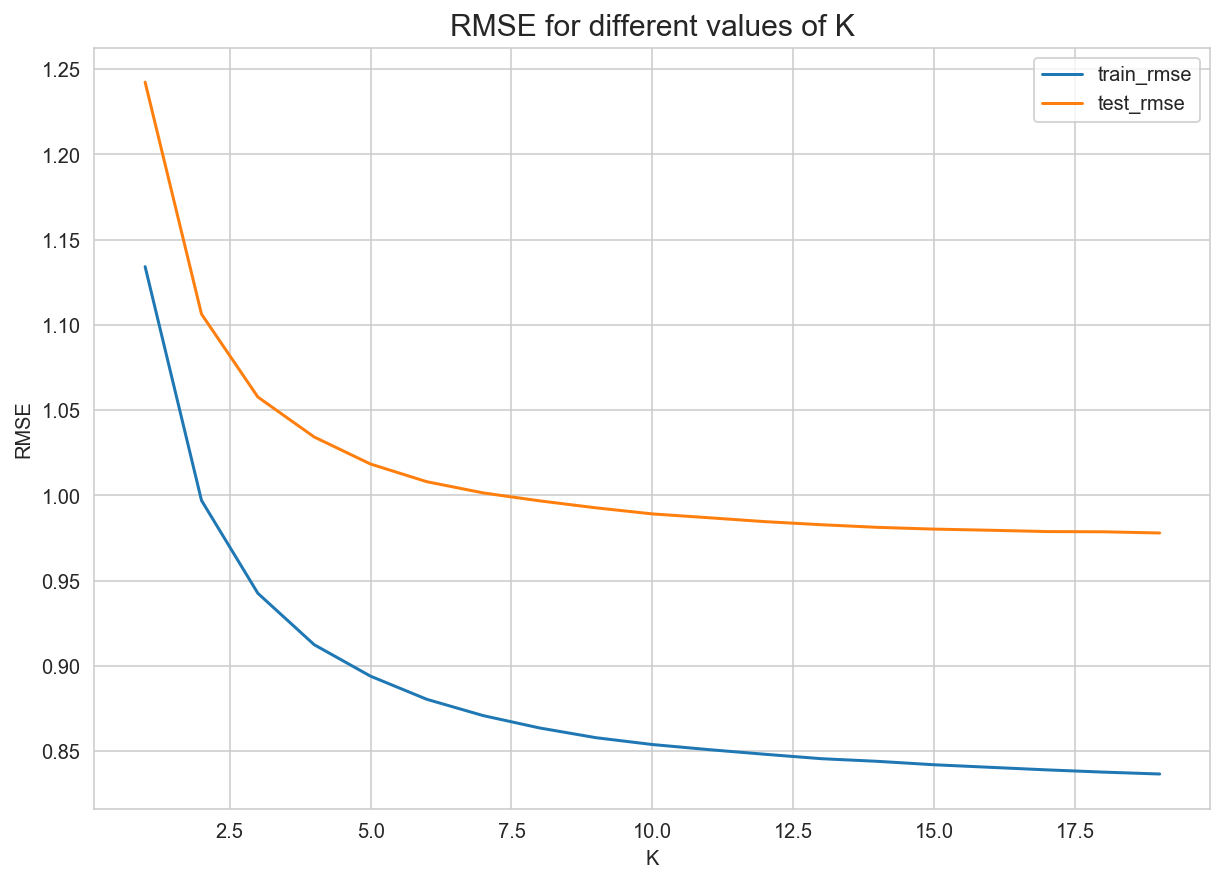

In [255]:
# Test using cosine similiarity

cos_scores_true = plot_rmse_kmeans(range(1,20), 'cosine', True, trainset, testset)

# Test RMSE reaches saturation at 1.04 after ~10 rounds, at 1.08 after 6 rounds

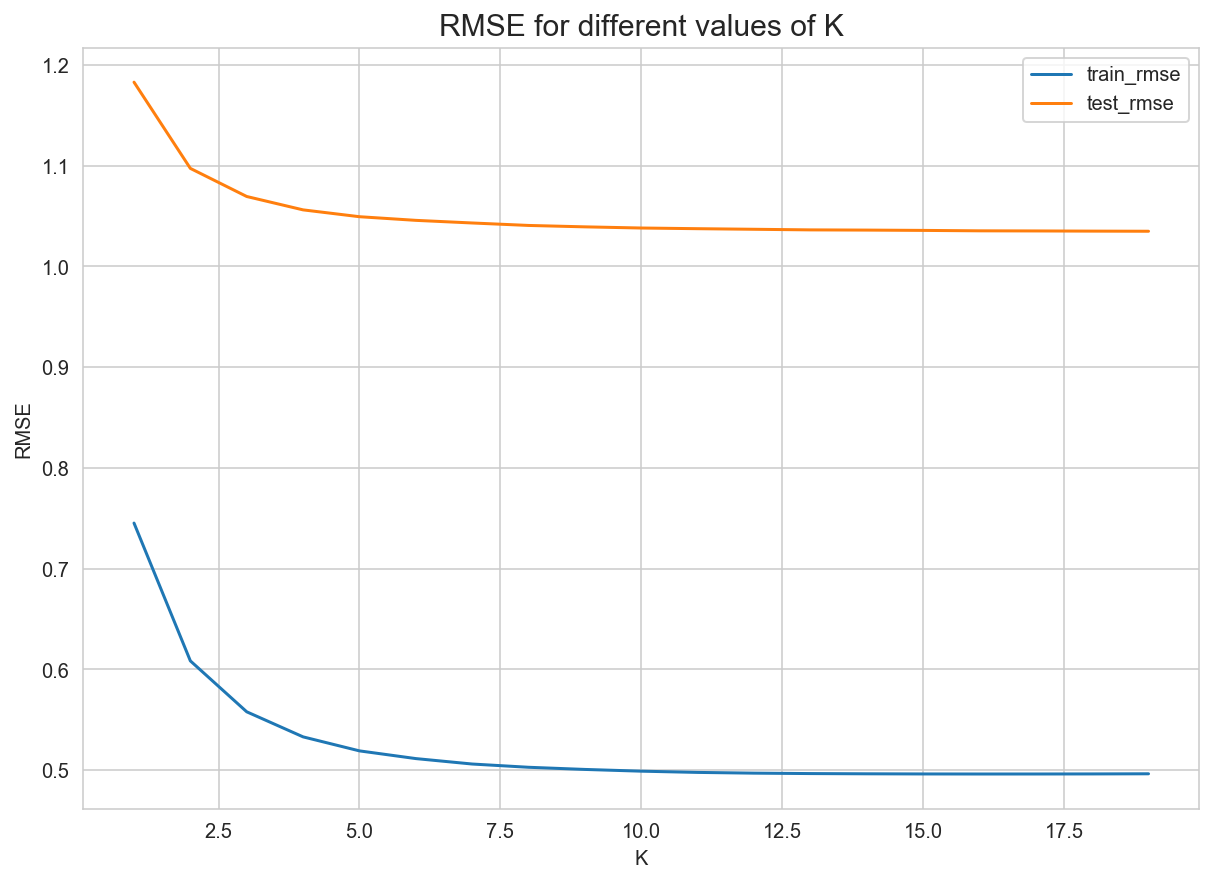

In [256]:
# Test using pearson similiarity

scores = plot_rmse_kmeans(range(1,20), 'pearson', True, trainset, testset)

# Test RMSE reaches saturation at about 1.1 after ~15 rounds, at 1.13 after 6 rounds

Based on the scores, it appears that using the cosine similarity measure results in a lower RMSE score, and the optimal k (which results in diminishing returns for higher k) is ~10. 

Let's evaluate both precision and recall scores for both cosine and pearson similarity measures

In [257]:
# Use Gridsearch to find optimal parameters

param_grid = {'k': range(40,61),
              'name': ['cosine', 'pearson'], 
              'user_based': [True],
              'verbose': [False]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 0.979992028778127
# {'k': 60, 'name': 'cosine', 'user_based': True, 'verbose': False}

0.979992028778127
{'k': 60, 'name': 'cosine', 'user_based': True, 'verbose': False}


In [258]:
# Cross-validate on data
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

#                   Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
# RMSE (testset)    0.9819  0.9770  0.9794  0.9902  0.9840  0.9825  0.0045  
# MAE (testset)     0.7614  0.7580  0.7594  0.7671  0.7625  0.7617  0.0031  
# Fit time          3.68    3.42    3.79    4.35    4.04    3.86    0.32    
# Test time         5.46    6.44    6.68    6.20    7.05    6.37    0.53  

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9819  0.9770  0.9794  0.9902  0.9840  0.9825  0.0045  
MAE (testset)     0.7614  0.7580  0.7594  0.7671  0.7625  0.7617  0.0031  
Fit time          3.68    3.42    3.79    4.35    4.04    3.86    0.32    
Test time         5.46    6.44    6.68    6.20    7.05    6.37    0.53    


{'test_rmse': array([0.98192427, 0.97696608, 0.97939532, 0.99017848, 0.98403372]),
 'test_mae': array([0.76143139, 0.7579792 , 0.75942571, 0.76705458, 0.76249686]),
 'fit_time': (3.676133155822754,
  3.4188499450683594,
  3.7918508052825928,
  4.348335027694702,
  4.041189193725586),
 'test_time': (5.4644176959991455,
  6.444761514663696,
  6.683124542236328,
  6.201413869857788,
  7.048147201538086)}

In [259]:
# Evaluate test set

algo.fit(trainset)

print("User-based Model : Test Set")
test_pred = algo.test(testset)
rmse(test_pred, verbose=True)

# User-based Model : Test Set
# RMSE: 0.9723

User-based Model : Test Set
RMSE: 0.9723


0.9723009053881385

**2)b)iii) Precision and Recall testing**

In [260]:
# Function to evaluate precision and recall score based on a set of predictions (and corresponding dataset). Parameters include 
# - No. of items to recommend
# - threshold rating - minimum rating required for an item to be recommended

def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # map predictions of each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse = True)

        # Check number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precisions@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 1
        
        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 1
        
    return precisions, recalls



In [261]:
# set up algo for cosine similarity measure and generate out scores
algo_cos = KNNWithMeans(k = 60, sim_options = {'name': 'cosine', 'user_based': True}, verbose = False)
algo_cos.fit(trainset)
predictions_cos = algo_cos.test(testset)

precisions, recalls = precision_recall_at_k(predictions_cos, k = 10, threshold = 3.5)

# Average precision and recall over all users
print('Precision score for cosine similarity measure :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for cosine similarity measure :', sum(rec for rec in recalls.values()) / len(recalls))

# Precision score for cosine similarity measure : 0.7983633042989611
# Recall score for cosine similarity measure : 0.7970824912015664

Precision score for cosine similarity measure : 0.7983633042989611
Recall score for cosine similarity measure : 0.7970824912015664


In [262]:
# set up algo for pearson similarity measure
algo_pear = KNNWithMeans(k = 60, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
algo_pear.fit(trainset)
predictions_pear = algo_pear.test(testset)

precisions, recalls = precision_recall_at_k(predictions_pear, k = 10, threshold = 3.5)

# Average precision and recall over all users
print('Precision score for pearson similarity measure :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for pearson similarity measure :', sum(rec for rec in recalls.values()) / len(recalls))

# Precision score for pearson similarity measure : 0.7754280451526867
# Recall score for pearson similarity measure : 0.7979755452577474

Precision score for pearson similarity measure : 0.7754280451526867
Recall score for pearson similarity measure : 0.7979755452577474


The recall score is about about the same for the cosine similarity measure as compared to the pearson similarity measure. Meanwhile, the precision score is also ~2% higher for the cosine similarity measure. 

### 2b)iv) Recommended restaurants

**For an existing user**

In [327]:
list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == 'gjhzKWsqCIrpEd9pevbKZw']['unique_store_id'])

['Sonic Drive-In (Outlet 1 - 89031)',
 'Metro Pizza (Outlet 1 - 89119)',
 'Garden Court Buffet',
 "Mr. Lucky's 24-7",
 'Aloha Specialties',
 "Chili's (Outlet 1 - 89108)",
 'India Oven',
 'In-N-Out Burger (Outlet 1 - 89119)',
 'The Buffet at Bellagio']

In [38]:
algo_cos = KNNWithMeans(k = 60, sim_options = {'name': 'cosine', 'user_based': True}, verbose = False)
algo_cos.fit(trainset)

# save rec_uucf_surprise pickle file
with open("rec_uucf_surprise.pkl", "wb") as f:
    pickle.dump(algo_cos, f)

In [5]:
# load rec_uucf_surprise pickle file
with open("rec_uucf_surprise.pkl", "rb") as f:
    algo_uucf = pickle.load(f)

In [136]:
# load using_rating_by_rest_exdate pickle file
with open("user_rating_by_rest_exdate.pkl", "rb") as f:
    user_rating_by_rest_exdate = pickle.load(f)

In [137]:
user_rating_by_rest_exdate.shape

(121950, 3)

In [138]:
# For existing users

def uucf_recom_currentuser(current_user_id, original_data, algo, n):
    '''
    Function that takes in a list of current user id and returns recommendations.
    
    Arguments:
    - current_user_id from database
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
#         if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == current_user_id]\
#                             ['unique_store_id']):
            rating = algo.predict(current_user_id, item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
#         else:
#             pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [140]:
# algo based on best performing in earlier testing
uucf_recom_currentuser('DUF9LYMMCCawUcnzzXDf4Q', user_rating_by_rest_exdate, algo_uucf, 4)

,Recommended Restaurants
1,Twist by Pierre Gagnaire
2,L&L Hawaiian Barbecue (Outlet 1 - 89103)
3,Snow Ono Shave Ice
4,Thai Food To Go


**For a new user**

In [37]:
def uucf_recom_newuser(new_restaurants, original_data, algo, n):
    '''
    Function that takes in a list of new restaurants and returns recommendations.
    
    Arguments:
    - new_restaurants : List of restaurants chosen by new user.
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''
    
    # Append new customer to a new dataframe, and assign a unique customer id
    new_data = pd.DataFrame({'user_id': ['newuser123']*len(new_restaurants),
                             'unique_store_id': new_restaurants,
                             'user_stars': [4]*len(new_restaurants)})
    combined_data = pd.concat([new_data, original_data]).reset_index(drop=True)
    
    # Initatialise dataset with surprise and do train-test split
    reader = Reader(rating_scale = (1,5))
    data = Dataset.load_from_df(combined_data[['user_id', 'unique_store_id', 'user_stars']], reader)
    trainset = data.build_full_trainset()
    
#     # This algo must be trained before this function is executed. 
    algo.fit(trainset)
    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
#         if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == 'newuser123']['unique_store_id']):
            rating = algo.predict('newuser123', item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
#         else:
#             pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [38]:
# Predict recommendation for new user

new_restaurants = ["Good Pie", "MB Steak", "Stripchezze Food Truck", "Ports O' Call Buffet"]

# algo based on best performing in earlier testing
uucf_recom_newuser(new_restaurants, user_rating_by_rest_exdate, algo_uucf, 10)

# 15-20 secs prediction

,Recommended Items
1,Naked City Pizza On Paradise
2,Original Tommy's Hamburgers
3,Kame Omakase
4,Yui Edomae Sushi
5,Honey Baked Ham Company (Outlet 1 - 89149)
6,Original Tommy's
7,Le Thai 2
8,Naked Fish's Sushi & Grill
9,Outback Steakhouse (Outlet 2 - 89109)
10,Joël Robuchon


### 2c) Item-Item Collaborative Filtering

$${\normalsize \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Baseline estimate for item $i$.<br>
$\sum\limits_{j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - Similarity between item $i$ and $j$.<br>
$(r_{uj} - \mu_j)$ - Deviation of rating for item $j$ and their baseline estimate.<br>

 ### 2c)i) Train and evaluate model - KNNwithMeans

1) Evaluate best RMSE using a range of k nearest neighbours across two different type of similarity measures: Cosine and Pearson

2) With the best k for each similarity measure, evaluate the precision and recall score

3) Finally for the best configuration across RMSE, precision and recall score, recommend the top restaurants for a given user profile (i.e. what restaurants he has previously liked)

In [287]:
# Set up data and apply train-test split

reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(user_rating_by_rest_exdate, reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 1)

**2c)ii) RMSE evaluation**

In [288]:
# Function to evaluate RMSE for with various parameters for K Means
# - Range of k
# - similarity type used

def plot_rmse_kmeans(k_range, similarity_type, user_based, trainset, testset):
    '''
    Function that takes in a range of k nearest neighbor values.
    Calculates the RMSE on train and test for each k and plot the curve.
    '''
    
    scores_dict = {'k': [], 'train_rmse': [], 'test_rmse': []}
    
    for k in k_range:
        algo = KNNWithMeans(k = k, sim_options = {'name': similarity_type, 'user_based': user_based}, verbose = False)
        algo.fit(trainset)
        
        train_pred = algo.test(trainset.build_testset())
        test_pred = algo.test(testset)
        
        train_rmse = rmse(train_pred, verbose = False)
        test_rmse = rmse(test_pred, verbose = False)
        
        scores_dict['k'].append(k)
        scores_dict['train_rmse'].append(train_rmse)
        scores_dict['test_rmse'].append(test_rmse)
        
    scores_df = pd.DataFrame(scores_dict)
    
    plt.figure(figsize = (10,7))
    plt.plot(scores_df['k'], scores_df['train_rmse'], label = 'train_rmse')
    plt.plot(scores_df['k'], scores_df['test_rmse'], label = 'test_rmse')
    plt.title('RMSE for different values of K', fontsize = 15)
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.legend()
    
    return scores_df

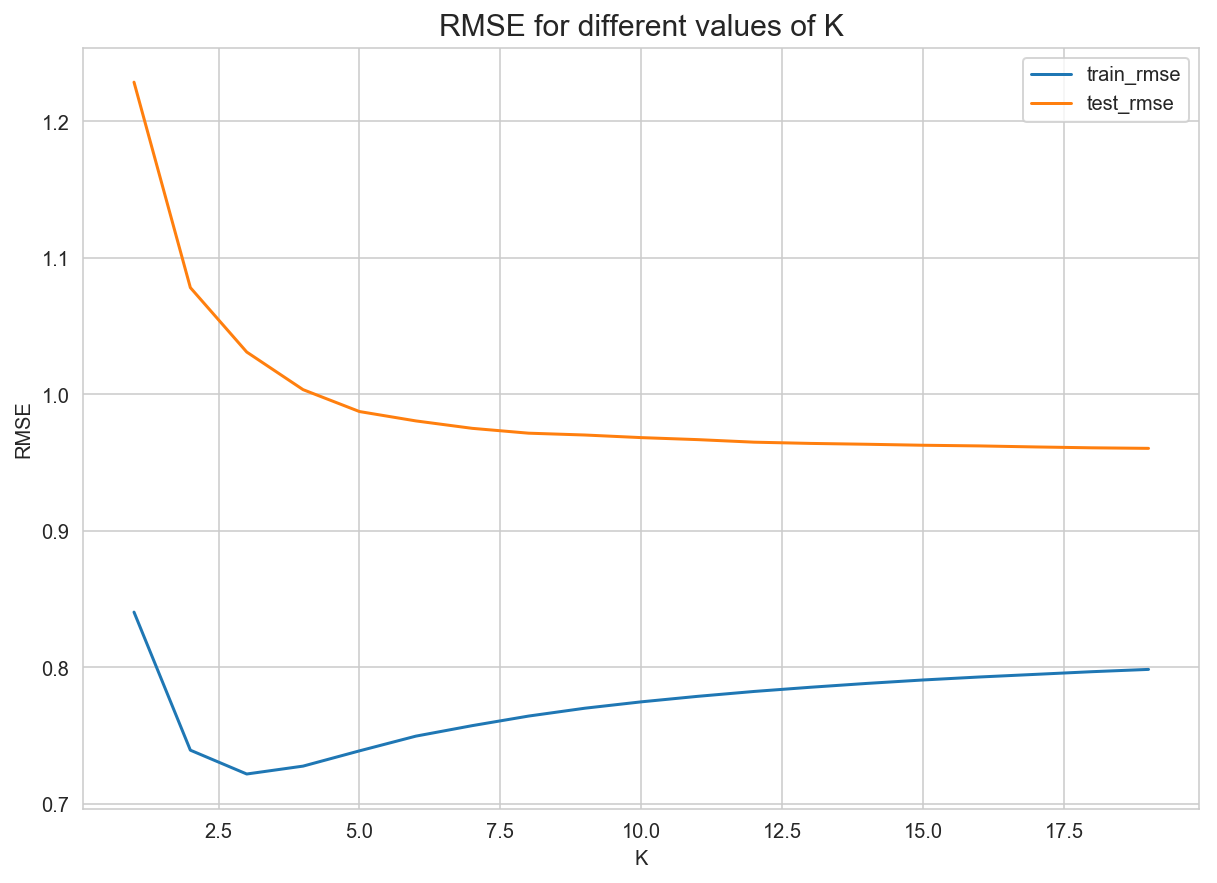

In [289]:
# Test using cosine similiarity

cos_scores_true = plot_rmse_kmeans(range(1,20), 'cosine', False, trainset, testset)

# Test RMSE reaches saturation at 1.04 after ~10 rounds, at 1.08 after 6 rounds

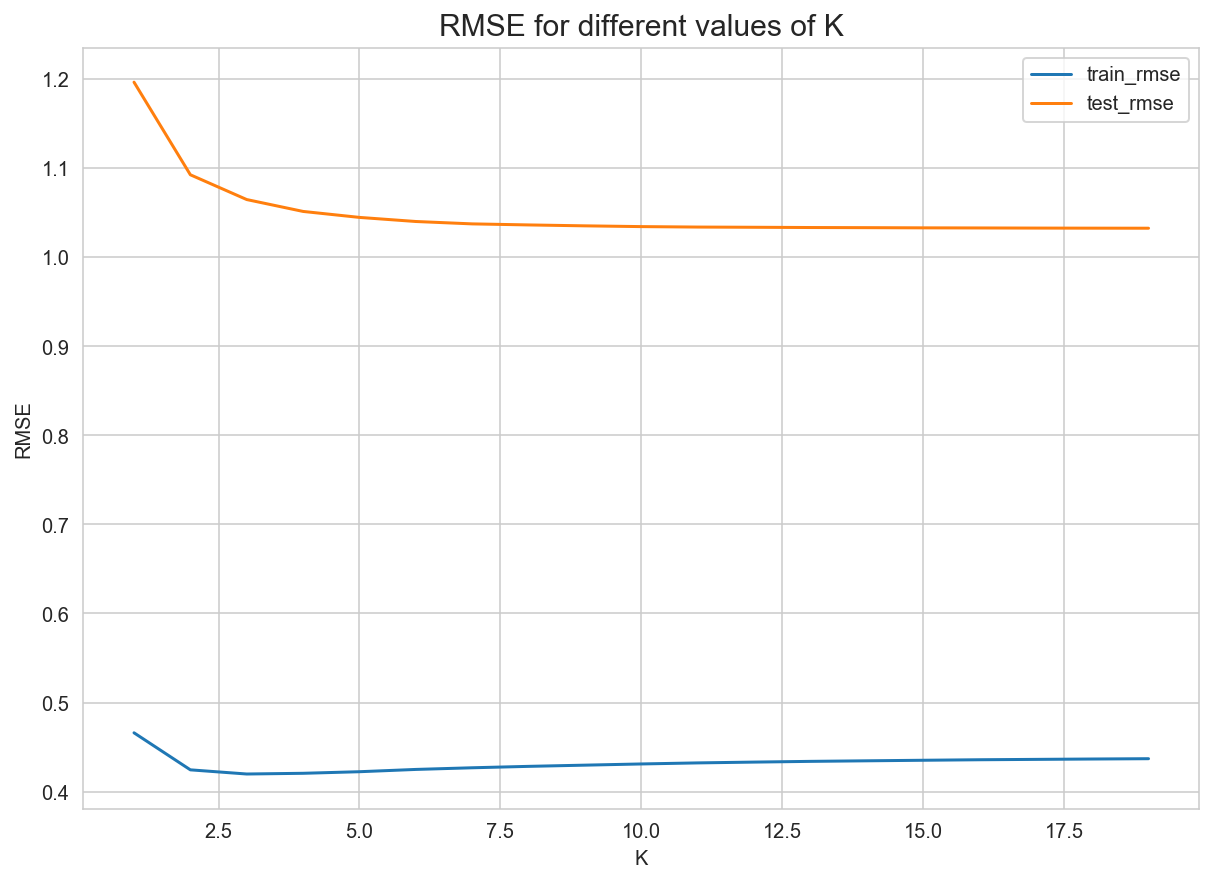

In [290]:
# Test using pearson similiarity

scores = plot_rmse_kmeans(range(1,20), 'pearson', False, trainset, testset)

# Test RMSE reaches saturation at about 1.1 after ~15 rounds, at 1.13 after 6 rounds

Based on the scores, it appears that using the cosine similarity measure results in a lower RMSE score, and the optimal k (which results in diminishing returns for higher k) is ~10. 

Let's evaluate both precision and recall scores for both cosine and pearson similarity measures

In [291]:
# Use Gridsearch to find optimal parameters

param_grid = {'k': range(40,61),
              'name': ['cosine', 'pearson'], 
              'user_based': [False],
              'verbose': [False]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 0.9801991560011363
# {'k': 60, 'name': 'cosine', 'user_based': False, 'verbose': False}

0.9801991560011363
{'k': 60, 'name': 'cosine', 'user_based': False, 'verbose': False}


In [292]:
# Cross validate on data

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

#                   Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
# RMSE (testset)    0.9784  0.9824  0.9794  0.9801  0.9780  0.9797  0.0015  
# MAE (testset)     0.7608  0.7646  0.7588  0.7605  0.7578  0.7605  0.0024  
# Fit time          5.65    5.99    5.93    5.97    6.70    6.05    0.35    
# Test time         9.69    9.64    10.82   11.21   12.11   10.69   0.94

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9784  0.9824  0.9794  0.9801  0.9780  0.9797  0.0015  
MAE (testset)     0.7608  0.7646  0.7588  0.7605  0.7578  0.7605  0.0024  
Fit time          5.65    5.99    5.93    5.97    6.70    6.05    0.35    
Test time         9.69    9.64    10.82   11.21   12.11   10.69   0.94    


{'test_rmse': array([0.97844057, 0.98239466, 0.97944786, 0.98010355, 0.97803407]),
 'test_mae': array([0.76079489, 0.76464326, 0.75875167, 0.76049796, 0.75779135]),
 'fit_time': (5.651265859603882,
  5.988607406616211,
  5.927207946777344,
  5.968084096908569,
  6.701697826385498),
 'test_time': (9.685948848724365,
  9.642728090286255,
  10.81572675704956,
  11.214109182357788,
  12.108109951019287)}

In [293]:
# Evaluate test set

algo.fit(trainset)

print("Item-based Model : Test Set")
test_pred = algo.test(testset)
rmse(test_pred, verbose=True)

# Item-based Model : Test Set
# RMSE: 0.9723

Item-based Model : Test Set
RMSE: 0.9723


0.9723009053881385

**2c)iii) Precision and Recall testing**

In [294]:
# Function to evaluate precision and recall score based on a set of predictions (and corresponding dataset). Parameters include 
# - No. of items to recommend
# - threshold rating - minimum rating required for an item to be recommended

def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # map predictions of each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse = True)

        # Check number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precisions@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 1
        
        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 1
        
    return precisions, recalls



In [295]:
# Still test both but choose best params from gridsearch

# set up algo for cosine similarity measure and generate out scores
algo_cos = KNNWithMeans(k = 60, sim_options = {'name': 'cosine', 'user_based': False}, verbose = False)
algo_cos.fit(trainset)
predictions_cos = algo_cos.test(testset)

precisions, recalls = precision_recall_at_k(predictions_cos, k = 10, threshold = 3.5)

# Average precision and recall over all users
print('Precision score for cosine similarity measure :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for cosine similarity measure :', sum(rec for rec in recalls.values()) / len(recalls))

# Precision score for cosine similarity measure : 0.7947331156870351
# Recall score for cosine similarity measure : 0.8195245133527163

Precision score for cosine similarity measure : 0.7947331156870351
Recall score for cosine similarity measure : 0.8195245133527163


In [296]:
# set up algo for pearson similarity measure
algo_pear = KNNWithMeans(k = 60, sim_options = {'name': 'pearson', 'user_based': False}, verbose = False)
algo_pear.fit(trainset)
predictions_pear = algo_pear.test(testset)

precisions, recalls = precision_recall_at_k(predictions_pear, k = 10, threshold = 3.5)

# Average precision and recall over all users
print('Precision score for pearson similarity measure :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for pearson similarity measure :', sum(rec for rec in recalls.values()) / len(recalls))

# Precision score for pearson similarity measure : 0.7744744488598099
# Recall score for pearson similarity measure : 0.7949128024550544

Precision score for pearson similarity measure : 0.7744744488598099
Recall score for pearson similarity measure : 0.7949128024550544


The recall score is about 1.2% higher for the cosine similarity measure as compared to the pearson similarity measure. Meanwhile, the precision score is also ~2% higher for the cosine similarity measure. 

In [66]:
algo_cos = KNNWithMeans(k = 60, sim_options = {'name': 'cosine', 'user_based': False}, verbose = False)
algo_cos.fit(trainset)

# save rec_uucf_surprise pickle file
with open("rec_iicf_surprise.pkl", "wb") as f:
    pickle.dump(algo_cos, f)

In [39]:
# load rec_uucf_surprise pickle file
with open("rec_iicf_surprise.pkl", "rb") as f:
    algo_iicf = pickle.load(f)

In [40]:
# load using_rating_by_rest_exdate pickle file
with open("user_rating_by_rest_exdate.pkl", "rb") as f:
    user_rating_by_rest_exdate = pickle.load(f)

### 2c)iv) Recommended restaurants

In [45]:
# For existing users

def iicf_recom_currentuser(current_user_id, original_data, algo, n):
    '''
    Function that takes in a list of current user id and returns recommendations.
    
    Arguments:
    - current_user_id from database
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''
    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
#         if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == current_user_id]['unique_store_id']):
            rating = algo.predict(current_user_id, item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
#         else:
#             pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [46]:
# Predict recommendation for existing user

# algo based on best performing in earlier testing
iicf_recom_currentuser('gjhzKWsqCIrpEd9pevbKZw', user_rating_by_rest_exdate, algo_iicf, 10)

# 15-20 secs prediction

,Recommended Items
1,Good Pie
2,Design & Dine
3,Scotch 80 Prime
4,El Frescos Cocina Mexicana
5,My Pie Pizza
6,Stripchezze Food Truck
7,MB Steak
8,Kame Omakase
9,Partage
10,Bajamar Seafood & Tacos


In [47]:
def iicf_recom_newuser(new_restaurants, original_data, algo, n):
    '''
    Function that takes in a list of new restaurants and returns recommendations.
    
    Arguments:
    - new_restaurants : List of restaurants chosen by new user.
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''
    
    # Append new customer to a new dataframe, and assign a unique customer id
    new_data = pd.DataFrame({'user_id': ['newuser123']*len(new_restaurants),
                             'unique_store_id': new_restaurants,
                             'user_stars': [4]*len(new_restaurants)})
    combined_data = pd.concat([new_data, original_data]).reset_index(drop=True)
    
    # Initatialise dataset with surprise and do train-test split
    reader = Reader(rating_scale = (1,5))
    data = Dataset.load_from_df(combined_data[['user_id', 'unique_store_id', 'user_stars']], reader)
    trainset = data.build_full_trainset()
    
#     # This algo must be trained before this function is executed. 
    algo.fit(trainset)
    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
        if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == 'newuser123']['unique_store_id']):
            rating = algo.predict('newuser123', item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
        else:
            pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [49]:
# Predict recommendation for new user

new_restaurants = ['360 Gourmet Bistro', '7th & Carson', '808 Tapas']

# algo based on best performing in earlier testing
iicf_recom_newuser(new_restaurants, user_rating_by_rest_exdate, algo_iicf, 10)

# 15-20 secs prediction

,Recommended Items
1,My Pie Pizza
2,Pizzeria Monzú
3,Cheba Hut Toasted Subs
4,Snow Ono Shave Ice
5,Stripchezze Food Truck
6,Partage
7,Garden Grill
8,Kame Omakase
9,Good Pie
10,El Frescos Cocina Mexicana


### 2d) Matrix Factorization - SVD

### 2d)i) Train and evaluate model - SVD

1) Evaluate best RMSE using a range of n latent factors, and by adjusting learning rates and regularization terms

2) With the best n, evaluate the precision and recall score

3) Finally for the best configuration across RMSE, precision and recall score, recommend the top restaurants for a given user profile (i.e. what restaurants he has previously liked)

In [298]:
# Set up data and apply train-test split

reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(user_rating_by_rest_exdate, reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 1)

**2d)ii) RMSE evaluation**

In [299]:
# Function to evaluate RMSE for with various parameters for n latent factors
# - Different number of n latent factors to test
# - similarity type used

def plot_rmse_svd(n_latent_factors, trainset, testset):
    '''
    Function that tanes in a range of n nearest neighbor values.
    Calculates the RMSE on train and test for each n and plot the curve.
    '''
    
    scores_dict = {'n_latent_factors': [], 'train_rmse': [], 'test_rmse': []}
    
    for n in n_latent_factors:
        algo = SVD(n, verbose = False)
        algo.fit(trainset)
        
        train_pred = algo.test(trainset.build_testset())
        test_pred = algo.test(testset)
        
        train_rmse = rmse(train_pred, verbose = False)
        test_rmse = rmse(test_pred, verbose = False)
        
        scores_dict['n_latent_factors'].append(n)
        scores_dict['train_rmse'].append(train_rmse)
        scores_dict['test_rmse'].append(test_rmse)
        
    scores_df = pd.DataFrame(scores_dict)
    
    plt.figure(figsize = (10,7))
    plt.plot(scores_df['n_latent_factors'], scores_df['train_rmse'], label = 'train_rmse')
    plt.plot(scores_df['n_latent_factors'], scores_df['test_rmse'], label = 'test_rmse')
    plt.title('RMSE for different values of n_latent_factors', fontsize = 15)
    plt.xlabel('n_latent_factors')
    plt.ylabel('RMSE')
    plt.legend()
    
    return scores_df

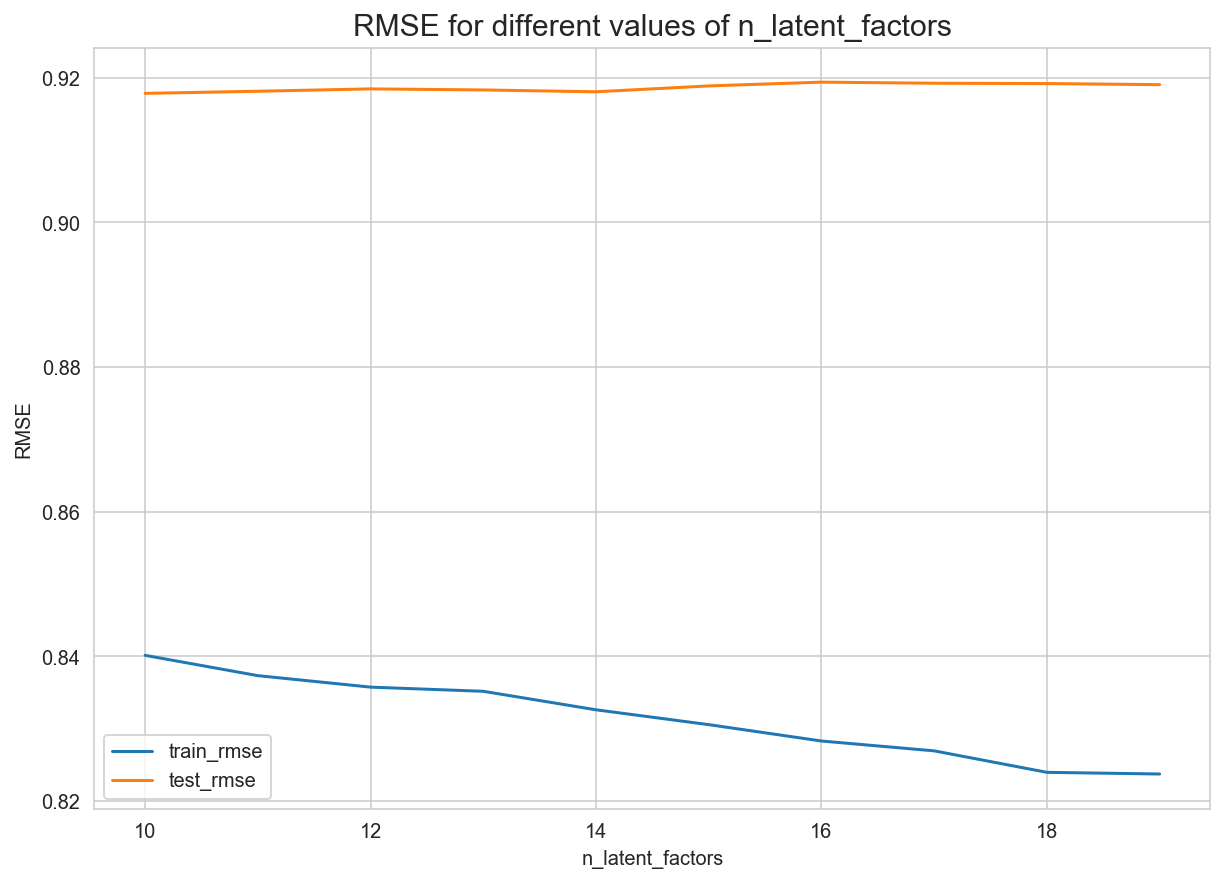

In [300]:
# Test using svd

cos_scores_true = plot_rmse_svd(range(10,20), trainset, testset)

# Test RMSE hovers around 1.02

In [301]:
# Use GridSearch to generate optimal settings for score

param_grid = {'n_factors': range(1,20),
              'n_epochs': [20, 30],
              'lr_all': [0.001, 0.005],
              'reg_all': [0.02, 0.10, 0.5],  
              'verbose': [False]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 0.9205194154622518
# {'n_factors': 1, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'verbose': False}

0.9205194154622518
{'n_factors': 1, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'verbose': False}


In [302]:
# Cross validate on data

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


# Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

#                   Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
# RMSE (testset)    0.9261  0.9264  0.9187  0.9220  0.9227  0.9232  0.0028  
# MAE (testset)     0.7268  0.7288  0.7203  0.7274  0.7250  0.7256  0.0029  
# Fit time          1.97    1.55    1.57    1.62    1.67    1.67    0.15    
# Test time         0.16    0.16    0.47    0.14    0.16    0.22    0.12     

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9261  0.9264  0.9187  0.9220  0.9227  0.9232  0.0028  
MAE (testset)     0.7268  0.7288  0.7203  0.7274  0.7250  0.7256  0.0029  
Fit time          1.97    1.55    1.57    1.62    1.67    1.67    0.15    
Test time         0.16    0.16    0.47    0.14    0.16    0.22    0.12    


{'test_rmse': array([0.92607226, 0.92640769, 0.91869669, 0.92198306, 0.9226829 ]),
 'test_mae': array([0.72677696, 0.72876567, 0.7202669 , 0.72736605, 0.7249601 ]),
 'fit_time': (1.9679524898529053,
  1.5480916500091553,
  1.5682733058929443,
  1.6160509586334229,
  1.671151876449585),
 'test_time': (0.16455888748168945,
  0.15618014335632324,
  0.46592092514038086,
  0.14062190055847168,
  0.15621614456176758)}

In [303]:
# Evaluate test set based on GridSearch params
print("User-based Model : Test Set")
test_pred = algo.test(testset)
rmse(test_pred, verbose=True)

# User-based Model : Test Set
# RMSE: 0.8686

User-based Model : Test Set
RMSE: 0.8686


0.8686487107297767

In [304]:
# Evaluate test set with regularization based on individual regularization/learning rate params

algo = SVD(n_factors = 2, lr_bu = 0.001, lr_pu = 0.001, reg_bu = 0.5, reg_pu = 0.5, verbose = False)
algo.fit(trainset)

print("User-based Model : Test Set")
test_pred = algo.test(testset)
rmse(test_pred, verbose=True)

# User-based Model : Test Set
# RMSE: 0.9305

User-based Model : Test Set
RMSE: 0.9305


0.9305386030355409

In [305]:
# Evaluate test set with regularization based on best params

algo = SVD(n_factors = 2, lr_all = 0.005, reg_all = 0.1, verbose = False)
algo.fit(trainset)

print("User-based Model : Test Set")
test_pred = algo.test(testset)
rmse(test_pred, verbose=True)

# User-based Model : Test Set
# RMSE: 0.9167

User-based Model : Test Set
RMSE: 0.9167


0.9167411644498517

Based on the scores, it appears that using the cosine similarity measure results in a lower RMSE score, and the optimal k (which results in diminishing returns for higher k) is 1. 

Let's evaluate both precision and recall scores for both cosine and pearson similarity measures

**2d)iii) Precision and Recall testing**

In [306]:
# Function to evaluate precision and recall score based on a set of predictions (and corresponding dataset). Parameters include 
# - No. of items to recommend
# - threshold rating - minimum rating required for an item to be recommended

def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # map predictions of each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse = True)

        # Check number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precisions@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 1
        
        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 1
        
    return precisions, recalls



In [307]:
# set up algo for SVD and generate out scores

algo_svd = SVD(n_factors = 2, lr_all = 0.005, reg_all = 0.1, verbose = False)
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)

precisions, recalls = precision_recall_at_k(predictions_svd, k = 10, threshold = 3.5)

# Average precision and recall over all users
print('Precision score for SVD :', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall score for SVD :', sum(rec for rec in recalls.values()) / len(recalls))

# Precision score for SVD : 0.7667481725292907
# Recall score for SVD : 0.8800586591424893

Precision score for SVD : 0.7667481725292907
Recall score for SVD : 0.8800586591424893


In [ ]:
# Predict recommendation for existing user

algo_svd = SVD(n_factors= 1, n_epochs = 20, lr_all = 0.005, reg_all = 0.1, verbose = False)

In [308]:
# save rec_svd_surprise pickle file
with open("rec_svd_surprise.pkl", "wb") as f:
    pickle.dump(algo_svd, f)

In [50]:
# load rec_uucf_surprise pickle file
with open("rec_svd_surprise.pkl", "rb") as f:
    algo_svd = pickle.load(f)

### 2d)iv) Recommended restaurants

In [92]:
# For existing users

def svd_recom_currentuser(current_user_id, original_data, algo, n):
    '''
    Function that takes in a list of current user id and returns recommendations.
    
    Arguments:
    - current_user_id from database
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''
    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
#         if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == current_user_id]['unique_store_id']):
            rating = algo.predict(current_user_id, item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
#         else:
#             pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [93]:
# algo based on best performing in earlier testing
svd_recom_currentuser('gjhzKWsqCIrpEd9pevbKZw', user_rating_by_rest_exdate, algo_svd, 10)

# 15-20 secs prediction

,Recommended Restaurants
1,Kame Omakase
2,Snow Ono Shave Ice
3,Stripchezze Food Truck
4,Partage
5,Pizzeria Monzú
6,Cheba Hut Toasted Subs
7,Alex
8,Good Pie
9,Meráki Greek Grill
10,Joël Robuchon


In [57]:
def svd_recom_newuser(new_restaurants, original_data, algo, n):
    '''
    Function that takes in a list of new restaurants and returns recommendations.
    
    Arguments:
    - new_restaurants : List of restaurants chosen by new user.
    - original_dataset: Original dataframe of users, items and ratings
    - algorithm used
    - n number of recommendations
    '''
    
    # Append new customer to a new dataframe, and assign a unique customer id
    new_data = pd.DataFrame({'user_id': ['newuser123']*len(new_restaurants),
                             'unique_store_id': new_restaurants,
                             'user_stars': [4]*len(new_restaurants)})
    combined_data = pd.concat([new_data, original_data]).reset_index(drop=True)
    
    # Initatialise dataset with surprise and do train-test split
    reader = Reader(rating_scale = (1,5))
    data = Dataset.load_from_df(combined_data[['user_id', 'unique_store_id', 'user_stars']], reader)
    trainset = data.build_full_trainset()
    
#     # This algo must be trained before this function is executed. 
    algo.fit(trainset)
    
    # Initiate recommended scores for every item in the catalog
    recommendations = {'items': [], 'rating': []}
    
    for item in original_data['unique_store_id'].unique():
#         if item not in list(user_rating_by_rest_exdate[user_rating_by_rest_exdate['user_id'] == 'newuser123']['unique_store_id']):
            rating = algo.predict('newuser123', item, verbose = False)[3]
            recommendations['items'].append(item)
            recommendations['rating'].append(rating)
#         else:
#             pass
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(recommendations).rename(columns={"items": "Recommended Restaurants"}).sort_values(by = 'rating', ascending = False)[:n].iloc[:, 0]
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    return recs_df    

In [58]:
# Predict recommendation for new user

new_restaurants = ['360 Gourmet Bistro', '7th & Carson', '808 Tapas']
algo_svd = SVD(n_factors= 1, n_epochs = 20, lr_all = 0.005, reg_all = 0.1, verbose = False)

# algo based on best performing in earlier testing
svd_recom_newuser(new_restaurants, user_rating_by_rest_exdate, algo_svd, 10)

# 15-20 secs prediction

,Recommended Items
1,Kame Omakase
2,Snow Ono Shave Ice
3,Stripchezze Food Truck
4,Partage
5,Pizzeria Monzú
6,Cheba Hut Toasted Subs
7,Alex
8,Meráki Greek Grill
9,Good Pie
10,Joël Robuchon


### 3) Content based filtering (Manual)

In [59]:
# load rest_reviews_nv_real pickle file
with open("rest_reviews_nv_real.pkl", "rb") as f:
    rest_reviews_nv_real = pickle.load(f)

In [120]:
# Group 
userbiz_group = rest_reviews_nv_real.groupby('user_id').agg({'name': lambda x: ', '.join(x)})

In [121]:
# save userbiz_group pickle file
with open("userbiz_group.pkl", "wb") as f:
    pickle.dump(userbiz_group, f)

In [60]:
rest_reviews_nv_real.head()

,review_id,business_id,user_id,user_stars,text,date,name,rest_avg_stars,review_count,categories,...,noise_lvl,credit_cards,wifi,alcohol,open_24hrs,serves_breakfast,serves_lunch,serves_dinner,is_chain,unique_store_id
1,lvEYRVCVtzkWs8HhO9NhCw,I4Nr-MVc26qWr08-S3Q1ow,7Inj11uN96hJUXAxrG2Saw,5.0,My wife ate here and I had pizza from another ...,2016-03-07,Greenberg's Deli,4.0,333,"Delis, Sandwiches, Pizza",...,average,1,1,1,0,1,1,1,0,Greenberg's Deli
5,Fid16Utz654-3h2Wb96ttA,I4Nr-MVc26qWr08-S3Q1ow,XKo5IT6o-WslzHPT69PRSQ,3.0,I had lunch for the first time at this locatio...,2013-02-22,Greenberg's Deli,4.0,333,"Delis, Sandwiches, Pizza",...,average,1,1,1,0,1,1,1,0,Greenberg's Deli
9,h-S9hbHrkV8rFegFqpdf_Q,I4Nr-MVc26qWr08-S3Q1ow,nCsfMqpfOGcTFKEZ3C1_Gg,4.0,this place makes a great pastrami or Reuben sa...,2013-12-08,Greenberg's Deli,4.0,333,"Delis, Sandwiches, Pizza",...,average,1,1,1,0,1,1,1,0,Greenberg's Deli
17,W1mPDutV0JZuaLBWgAWxTA,I4Nr-MVc26qWr08-S3Q1ow,51UaY_JKrEOzA1CeEbuDNg,4.0,"The New York, New York does the ""Food Court"" i...",2007-12-12,Greenberg's Deli,4.0,333,"Delis, Sandwiches, Pizza",...,average,1,1,1,0,1,1,1,0,Greenberg's Deli
24,XqPkNCAVDBbEawwfZVzPGw,I4Nr-MVc26qWr08-S3Q1ow,nW4POvJR2MqjU90mnNPqvA,4.0,Alright I have to admit..I'm still dreaming of...,2010-05-17,Greenberg's Deli,4.0,333,"Delis, Sandwiches, Pizza",...,average,1,1,1,0,1,1,1,0,Greenberg's Deli


In [61]:
# Merge all the review text for each restaurant (In case if going to use)

concat_text_col = rest_reviews_nv_real.groupby('business_id')['text'].apply(lambda x: x.sum().replace("\r", "")
                                                                      .replace("\n", "")).reset_index()
concat_text_col.shape

(1713, 2)

In [62]:
concat_text_col.head()

,business_id,text
0,-3zffZUHoY8bQjGfPSoBKQ,What an amazing dinner. The service was excell...
1,-9YyInW1wapzdNZrhQJ9dg,After a long day walking the convention floor ...
2,-BmqghX1sv7sgsxOIS2yAg,I love this place. Everyone I tell that I eat ...
3,-FNquqGseSCVMWo7KbK-Tg,"It's a Chipotle, like all the other Chipotles...."
4,-JFVxwdVQfX207554dx1nw,Located in close proximity to the buffed and t...


In [63]:
# Extract restaurants that have been filtered and reviwed 

businesses_reviewed = rest_reviews_nv_real.drop(['review_id', 'user_id', 'user_stars', 'text', 'date'], axis = 1).drop_duplicates().reset_index(drop = True)
businesses_reviewed.shape

(1713, 25)

In [64]:
# Concatenate text col with main body

businesses_reviewed = pd.concat([businesses_reviewed, concat_text_col['text']], axis = 1)

In [65]:
businesses_reviewed.to_csv('businesses_reviewed.csv', index = False)

In [66]:
businesses_reviewed.columns

Index(['business_id', 'name', 'rest_avg_stars', 'review_count', 'categories',
       'postal_code', 'latitude', 'longitude', 'pricerange', 'is_open',
       'outdoor_seat', 'rest_good_for_groups', 'good_kids', 'rest_reserve',
       'rest_deliver', 'noise_lvl', 'credit_cards', 'wifi', 'alcohol',
       'open_24hrs', 'serves_breakfast', 'serves_lunch', 'serves_dinner',
       'is_chain', 'unique_store_id', 'text'],
      dtype='object')

In [67]:
businesses_reviewed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 26 columns):
business_id             1713 non-null object
name                    1713 non-null object
rest_avg_stars          1713 non-null float64
review_count            1713 non-null int64
categories              1713 non-null object
postal_code             1710 non-null float64
latitude                1713 non-null float64
longitude               1713 non-null float64
pricerange              1713 non-null int64
is_open                 1713 non-null int64
outdoor_seat            1713 non-null int64
rest_good_for_groups    1713 non-null int64
good_kids               1713 non-null int64
rest_reserve            1713 non-null int64
rest_deliver            1713 non-null int64
noise_lvl               1713 non-null object
credit_cards            1713 non-null int64
wifi                    1713 non-null int64
alcohol                 1713 non-null int64
open_24hrs              1713 non-null int64
s

In [133]:
a = 'hello'
b = 'goodbye'
c = 'geez'

In [135]:
temp_list = []
temp_list.append(a)
temp_list

['hello']

### Assess content based filtering based on non review text features

In [68]:
# Prepare data for modelling

# Select numerical columns for modelling - include unique store id for identification
num_col = ['unique_store_id', 'rest_avg_stars', 'review_count', 'pricerange', 'is_open', 'outdoor_seat', 
           'rest_good_for_groups', 'good_kids', 'rest_reserve', 'rest_deliver', 'credit_cards', 'wifi', 'alcohol',
          'open_24hrs', 'serves_breakfast', 'serves_dinner', 'is_chain']

start_col = 'rest_avg_stars'
end_col = 'is_chain'

num_matrix = businesses_reviewed[num_col]
num_matrix = num_matrix.reset_index() # This produces a separate index
num_matrix.rename({'index': 'restaurant'}, axis = 1, inplace = True)

# Create a non_num_matrix for 'categories' and 'text' column to be count vectorized and apply get_dummies to 'noise_lvl' attribute
cvec = CountVectorizer(stop_words = 'english', max_features = 2000, min_df = 3)
non_num_matrix = pd.DataFrame(cvec.fit_transform(businesses_reviewed['categories']).toarray(), columns = cvec.get_feature_names())
noise_matrix = pd.get_dummies(businesses_reviewed['noise_lvl'], prefix = 'noiselvl')
non_num_matrix = pd.concat([non_num_matrix, noise_matrix], axis = 1)

In [70]:
# Concat both numeric and non-numeric matrices

res_matrix = pd.concat([num_matrix, non_num_matrix], axis = 1)

In [72]:
res_matrix.shape

(1713, 197)

In [75]:
# Prep restaurant matrix file for filtering. Save rec_svd_surprise pickle file
with open("cbf_res_matrix.pkl", "wb") as f:
    pickle.dump(res_matrix, f)

In [122]:
# load restaurant matrix pickle file
with open("cbf_res_matrix.pkl", "rb") as f:
    res_matrix = pickle.load(f)

In [120]:
# Group restaurants by user for filtering
userbiz_group = rest_reviews_nv_real.groupby('user_id').agg({'name': lambda x: ', '.join(x)})

# save userbiz_group pickle file
with open("userbiz_group.pkl", "wb") as f:
    pickle.dump(userbiz_group, f)

In [130]:
# load pickle file of businesses visited by every individual

with open("userbiz_group.pkl", "rb") as f:
    userbiz_group = pickle.load(f)

In [131]:
# Content based similarity for EXISTING users

def content_recom_currentuser(username, res_matrix, num_recommended_res, start_col = 'rest_avg_stars', end_col = 'noiselvl_very_loud', 
                        num_similar_res = 20):
    
    # Get restaurants visited by username
    res_list = userbiz_group.loc[username][0].split(', ')
    
    unique_res_list = []
    for res in res_list:
        # Get index of restaurant list 
        unique_res_list.extend(res_matrix[res_matrix['unique_store_id'] == res].index)
    # Get similar customers' restaurants index preferences    
    unique_res_list = np.unique(unique_res_list)

    # Generate average scores of the restarant list
    df_ref = pd.DataFrame(columns = res_matrix.loc[:, start_col:].columns)
    # provide list of indices from the list of restaurants and all cols
    df_ref.loc[0, :] = res_matrix.loc[unique_res_list, start_col:].mean()
    
    # Generate restaurant similarity between res_list and the rest of the other restaurants
    res_similarity = cosine_similarity(df_ref, res_matrix.loc[:, start_col:])
    
    # Find top n most similar res to avg of restaurant list by cosine similarity score
    unique_res_list_id = np.argsort(res_similarity)[0][-(num_similar_res + 1):-1]
    
    # Sort by number of stars
    top_n_recommended_res = res_matrix.loc[unique_res_list_id, 'rest_avg_stars'].sort_values(ascending = False)[: num_recommended_res].index.tolist()
        
    top_n_res_name = []
    for ind in top_n_recommended_res:
          top_n_res_name.append(res_matrix.loc[ind, 'unique_store_id'])
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(top_n_res_name, columns = ['Recommended Restaurants'])
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    
    return recs_df

In [132]:
content_recom_currentuser('DUF9LYMMCCawUcnzzXDf4Q', res_matrix, 5)

,Recommended Restaurants
1,Juan's Flaming Fajitas & Cantina
2,Bruxie
3,Egg Works (Outlet 1 - 89120)
4,Hobak Korean BBQ
5,Soho Japanese Restaurant


In [127]:
# Content based similarity for new users

def content_recom_newuser(res_list, res_matrix, num_recommended_res, start_col = 'rest_avg_stars', end_col = 'noiselvl_very_loud', 
                        num_similar_res = 20):
    unique_res_list = []
    for res in res_list:
        # Get index of restaurant list 
        unique_res_list.extend(res_matrix[res_matrix['unique_store_id'] == res].index)
    # Get similar customers' restaurants index preferences    
    unique_res_list = np.unique(unique_res_list)

    # Generate average scores of the restarant list
    df_ref = pd.DataFrame(columns = res_matrix.loc[:, start_col:].columns)
    # provide list of indices from the list of restaurants and all cols
    df_ref.loc[0, :] = res_matrix.loc[unique_res_list, start_col:].mean()
    
    # Generate restaurant similarity between res_list and the rest of the other restaurants
    res_similarity = cosine_similarity(df_ref, res_matrix.loc[:, start_col:])
    
    # Find top n most similar res to avg of restaurant list by cosine similarity score
    unique_res_list_id = np.argsort(res_similarity)[0][-(num_similar_res + 1):-1]
    
    # Sort by number of stars
    top_n_recommended_res = res_matrix.loc[unique_res_list_id, 'rest_avg_stars'].sort_values(ascending = False)[: num_recommended_res].index.tolist()
        
    top_n_res_name = []
    for ind in top_n_recommended_res:
          top_n_res_name.append(res_matrix.loc[ind, 'unique_store_id'])
    
    # Take top n items and recommend to user
    recs_df = pd.DataFrame(top_n_res_name, columns = ['Recommended Restaurants'])
    recs_df.index = np.arange(1, len(recs_df) + 1)
    recs_df = pd.DataFrame(recs_df)
    
    
    return recs_df

In [128]:
content_recom_newuser(["Greenberg's Deli", 'Casanova'], res_matrix, 5)

,Recommended Restaurants
1,Meráki Greek Grill
2,Gorilla Sushi
3,Pure Indian Cuisine
4,El Sombrero Mexican Bistro
5,A.Y.C.E. Buffet
